In [1]:
from cmath import sin
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import signal
from Audio_data import Audio_data
from Matrix_array import Matrix_array
from Audio_source import Audio_source
from Color_map import Color_map

# GLOBAL VARIABLES
c = 340                     # propagation speed of sound

In [2]:
def antenna_setup():
    r_a1 = [-0.08,0,0]
    r_a1 = [0.08,0,0]
    uni_distance = math.pow(10,-3) * 20
    row_elements = 8
    column_elements = 8

    array_matrix_1 = Matrix_array(r_a1,uni_distance,row_elements,column_elements)
    array_matrix_2 = Matrix_array(r_a2,uni_distance,row_elements,column_elements)
    array_matrices = np.array([array_matrix_1, array_matrix_2], dtype=object)

    sub_arrays = len(array_matrices)

    for array in range(sub_arrays):
        plt.title('Array setup')
        plt.scatter(array_matrices[array].get_r_prime()[0,:], array_matrices[array].get_r_prime()[1,:])
        
    return array_matrices

In [3]:
def generate_array_signals(matrix_array, sources, t):
    r_prime = matrix_array.get_r_prime()
    Audio_signal = np.zeros((len(t), len(r_prime[0,:])))

    for sample in range(len(t)):
        if (sample+1 in np.linspace(0,len(t),11)) or (sample == 0): # print stuff so user know how many samples that have been generated
            print(sample+1)                                         # print stuff so user know how many samples that have been generated
        for mic in range(len(r_prime[0,:])):
            x_i = r_prime[0,mic]
            y_i = r_prime[1,mic]
            temp_signal_sample = 0
            for source in range(len(sources)):
                if (sources[source].get_t_start() < t[sample]) and (t[sample] < sources[source].get_t_end()):
                    frequencies_ps = sources[source].get_frequency()
                    theta_source = sources[source].get_theta()
                    phi_source = sources[source].get_phi()
                    rho_soruce = sources[source].get_rho()
                    for freq_ind in range(len(frequencies_ps)):
                        k = 2*math.pi*frequencies_ps[freq_ind]/c
                        r_1 = np.array([x_i,y_i,0])
                        r_2 = rho_soruce * r_vec(theta_source,phi_source)
                        norm_coeff = np.linalg.norm(r_2-r_1)
                        phase_offset = -k*norm_coeff
                        element_amplitude = 1/norm_coeff
                        temp_signal_sample += element_amplitude * math.sin(2*math.pi* frequencies_ps[freq_ind] * t[sample] + phase_offset)
            Audio_signal[sample,mic] = temp_signal_sample
    return Audio_signal

In [4]:
def r_vec(theta,phi):
    r = np.array([(math.sin(theta)*math.cos(phi)), math.sin(theta)*math.sin(phi), math.cos(theta)])
    return r

In [5]:
def filtering(array_audio_signals, sub_arrays, frequency_bands, f_sampling, elements):
    #print('sub_arrays: '+str(sub_arrays))
    audio_filtered_complete = np.zeros((sub_arrays, len(frequency_bands)), dtype=object)
    for array in range(sub_arrays):
        Audio_signal = array_audio_signals[array].get_audio_signals()

        for freq_ind in range(len(frequency_bands)):
            # filter design for each band
            filter_order = 200
            nu_0 = 2*frequency_bands[freq_ind]/f_sampling   # normalized frequency
            scale_factor = 10000                            # scale factor, making filter bandwidth more narrow
            cut_off = [nu_0 - nu_0/scale_factor, nu_0 + nu_0/scale_factor]

            b = signal.firwin(filter_order, cut_off, window="hamming", pass_zero=False) # filter coefficients
            audio_temp = np.zeros((len(Audio_signal[:,0]),elements))
            for mic_ind in range(elements):
                # apply filter on every signal recorded from the elements
                audio_temp[:,mic_ind] = signal.lfilter(b, 1.0, Audio_signal[:,mic_ind])

            audio_filtered_complete[array,freq_ind] = Audio_data(audio_temp)
            
            # plot all filters
            plt.figure(2)
            w, h = signal.freqz(b, worN=8000)
            H = 20*np.log10(abs(h))
            plt.plot((w/math.pi)*f_sampling/2, 20*np.log10(abs(h)), linewidth=2)
            plt.xlabel('Frequency (Hz)')
            plt.ylabel('Gain (dB)')
            plt.title('Frequency Response of all filters')
            plt.ylim(-5, 0.5)
            plt.xlim(70, f_sampling/2)
            plt.grid(True)

        #print(audio_filtered_complete[array,freq_ind].get_audio_signals())
        #print(audio_filtered_complete[array,1].get_audio_signals())
    #print(audio_filtered_complete.shape)
    #print(array)
    #print(audio_filtered_complete[array,1].get_audio_signals())
    #print(audio_filtered_complete[1,1].get_audio_signals())
    print('Filtering of signals completed.')
    return audio_filtered_complete

In [6]:
def scanning(y_listen, x_listen, r_scan, frequency_bands, audio_filtered_complete, array_matrices, f_sampling, sub_arrays):
    # Start scanning
    color_maps_complete = np.zeros(len(frequency_bands), dtype=object)
    for freq_ind in range(len(frequency_bands)):
        color_map_new = np.zeros((len(y_listen),len(x_listen)))
        color_maps_complete[freq_ind] = Color_map(color_map_new)
    for x_ind in range(len(x_listen)):
        print('\n x_ind: '+str(x_ind+1))                # print stuff for user
        x = x_listen[x_ind]                             # current x-coordinate
        print('\t y_ind:', end=' ')                     # print stuff for user
        for y_ind in range(len(y_listen)):
            print(str(y_ind+1), end=' ')                # print stuff for user
            y = y_listen[y_ind]                         # current x-coordinate
            z_0 = math.sqrt(r_scan**2 - x**2 - y**2)
            theta = math.acos(z_0/r_scan)               # get theta from our x,y coordinates
            phi = math.atan2(y,x)                       # get phi from our x,y coordinates
            for freq_ind in range(len(frequency_bands)):
                # apply beamforming algo. in every frequency band
                frequency = frequency_bands[freq_ind]
                mic_data = 0                            #create empty mic data

                for array in range(sub_arrays):
                    # Use the filtered audio signals
                    audio_temp_signals = audio_filtered_complete[array, freq_ind].get_audio_signals()
                    
                    # Adaptive configuration of the antanna array
                    adaptive_weight = adaptive_array_config(array_matrices[array], frequency)
                    
                    # Perform the beamforming algoritm (phase-shift input signal according to listening direction)
                    mic_data = mic_data + beam_forming_algorithm(array_matrices[array],[theta,phi],adaptive_weight, audio_temp_signals, frequency, f_sampling)
                
                # obtain relative power in the listening direction
                color = sum(abs(mic_data)**2)

                # relative power inte the direction [theta, phi] saved in matrix
                color_maps_complete[freq_ind].set_color(y_ind, x_ind, color)
    return color_maps_complete

In [7]:
def adaptive_array_config(matrix_array, frequency):
    # Adaptive configuration of the antanna array
    # Selects only necessary antenna-elements to maintain small beamwidth

    row_elements = matrix_array.get_row_elements()
    column_elements = matrix_array.get_row_elements()
    uni_distance = matrix_array.get_uni_distance()
    
    wavelength = c/frequency                    # wavelength of signal
    wavelength_rel = uni_distance/wavelength    # relative wavelenght to distance between microphone elements

    if wavelength_rel>0.1581:
        # mode 1
        weight = np.ones((1, row_elements*column_elements))
        return weight
    elif (wavelength_rel <= 0.156) and (wavelength_rel > 0.0986):
        mode = 3
    elif (wavelength_rel <= 0.0986) and (wavelength_rel > 0.085):
        mode = 5
    elif (wavelength_rel <= 0.085) and (wavelength_rel > 0.07):
        mode = 6
    else:
        mode = 7

    weight = np.zeros((1,row_elements*column_elements))
    row_lim = math.ceil(row_elements/mode)
    column_lim = math.ceil(column_elements/mode)

    for i in range(row_lim):
        for j in range(column_lim):
            element_index = (mode*i*row_elements + mode*j) # this calculation could be wrong thanks to matlab and python index :))
            weight[0,element_index] = 1
    return weight

In [8]:
def beam_forming_algorithm(matrix_array,direction,weight,audio_signal,frequency,sampling_frequency):
    #
    #   IMPORTANT! The beamforming algorithm assumes the array matrices lies in the xy-plane
    #
    #   The beamforming algorithm calculates the necessary phase to introduce to the narrowband signal
    #   in order to have the maximum directivity in the direction r(theta,phi)
    #
    #   This phase-shift is introduced by a phase shifting function, which acts as a filter in time domain.
    #
    #   To improve performance, all elements of the array matrices are not in use. The user decides which 
    #   element to use by sending in a weight vectir as a argument. The output signal is then normalized after
    #   how many elements where in use.

    #   Get the amount of samples of the audio tracks 
    samples = len(audio_signal[:,0])

    #   The listening-direction vector contains two scalar values, theta and phi
    theta = direction[0]
    phi = direction[1]

    #   The r_prime vector of the matrix array to know the location of every element, as well as how many 
    #   elements exists.
    r_prime = matrix_array.get_r_prime()
    elements = matrix_array.get_elements()

    #   The narrowband wavevnumber
    k = 2*math.pi*frequency/c

    #   The normalized frequency
    ny = frequency/sampling_frequency

    #   Initialize output vector
    mic_data = np.zeros((samples,1))

    #   The compensation factors to obtain uniform phase in the direction r_hat(theta,phi)
    x_factor = math.sin(theta)*math.cos(phi)
    y_factor = math.sin(theta)*math.sin(phi)

    for mic_ind in range(elements):
        #   calculate the narrowband phase-shift
        phase_shift_value = -k*(r_prime[0,mic_ind] * x_factor + r_prime[1,mic_ind]*y_factor)

        #   Sum the individually shifted data from the atnenna elements as well as weight them with
        #   appropriate weight.
        mic_data = mic_data + weight[0,mic_ind] * phase_shift(audio_signal[:,mic_ind],ny,phase_shift_value)

    norm_coeff = 1/sum(weight[0])
    mic_data = mic_data * norm_coeff

    return mic_data

In [9]:
def phase_shift(x,ny,phase):
    #   Input signal x
    #
    #   Output signal y
    #
    #   if x = cos(n*2*pi*ny), then y = cos(n*2*pi*ny + phase)
    #
    x_length = len(x)
    y = np.zeros((x_length,1))

    for i in range(x_length-1):
        y[i] = math.cos(phase) * x[i] + math.sin(phase)/(2*math.pi*ny)*(x[i+1]/2 - x[i-1]/2)
    
    return y

In [10]:
def extents(f):
    # function to show images with correct grid values (with plt.imshow()), corresponding to our scanning window
    delta = f[1]-f[0]
    return [f[0] - delta/2, f[-1] + delta/2]

In [11]:
def validation_check(y_listen, x_listen, sources, r_scan):
    # Validation check
    xy_val_check = np.zeros((len(y_listen),len(x_listen)))

    for x_ind in range(len(x_listen)):
        x = x_listen[x_ind]
        for y_ind in range(len(y_listen)):
            y = y_listen[y_ind]
            temp_val = 0
            for source_ind in range(len(sources)):
                x_s = r_scan * math.sin(sources[source_ind].get_theta()) * math.cos(sources[source_ind].get_phi())
                y_s = r_scan * math.sin(sources[source_ind].get_theta()) * math.sin(sources[source_ind].get_phi())
                temp_val += 1/math.sqrt(((x_s -x)**2 + (y_s - y)**2))
            xy_val_check[y_ind, x_ind] = temp_val

    plt.figure(3)
    plt.imshow(xy_val_check, extent= extents(x_listen) + extents(y_listen))
    plt.title('Actual location of sources')

In [ ]:
def show_beamforming_results(y_listen, x_listen, color_maps):
    color_map_intensity = np.zeros((len(y_listen), len(x_listen)))
    for freq_ind in range(len(frequency_bands)):
        color_map_intensity += color_maps[freq_ind].get_color_data_matrix()
    plt.figure(4)
    plt.imshow(color_map_intensity, extent= extents(x_listen) + extents(y_listen))
    plt.title('Beamforming results')
    return color_map_intensity

In [12]:
def maximum_intensity(color_maps_complete, frequency_bands):
    # Get maximum intensity of a signals, at any frequency
    max_intensity = 0
    for freq_ind in range(len(frequency_bands)):
        intensity = np.max(np.max(color_maps_complete[freq_ind].get_color_data_matrix()))
        if intensity > max_intensity:
            max_intensity = intensity
    return max_intensity

In [13]:
# Initialization
f_sampling = 1000           # sampling frequency in Hz
t_start = 0                 # start time of simulation 
t_end = 1                  # end time of simulation
t_total = t_end - t_start   # total simulation time
t = np.linspace(t_start, t_end, t_total*f_sampling) # time vector

# Point audio source
away_distance = 700         # distance between the array and sources

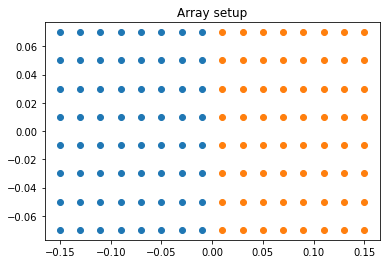

In [14]:
# set up arrays
array_matrices = antenna_setup()
sub_arrays = len(array_matrices)


In [15]:
# Create and place out sources
sources = np.array([Audio_source(300, 400, 20, 20, 140, away_distance, 0, 1.5)])

print(sources[0].get_theta())
print(sources[0].get_phi())
print(sources[0].get_frequency())
print(sources[0].get_t_start())
print(sources[0].get_t_end())
print(sources[0].get_rho())

0.3490658503988659
2.443460952792061
[300.         305.26315789 310.52631579 315.78947368 321.05263158
 326.31578947 331.57894737 336.84210526 342.10526316 347.36842105
 352.63157895 357.89473684 363.15789474 368.42105263 373.68421053
 378.94736842 384.21052632 389.47368421 394.73684211 400.        ]
0
1.5
700


In [16]:
# GENERATE AUDIO SIGNALS
array_audio_signals = np.zeros((sub_arrays), dtype=object)
print('Number of samples generated (of '+str(f_sampling*t_total)+'):')
for array in range(sub_arrays):
    # generate the audio signals on each array-element for each sub-array
    temp_signal = generate_array_signals(array_matrices[array],sources,t)
    array_audio_signals[array] = Audio_data(temp_signal)
    print('Audio signal for array '+str(array+1)+' generated')


Number of samples generated (of 1000):
1
100
200
300
400
500
600
700
800
900
1000
Audio signal for array 1 generated
1
100
200
300
400
500
600
700
800
900
1000
Audio signal for array 2 generated


In [17]:
# BEAMFORMING values
x_res = 10                          # resolution in x
y_res = 10                          # resolution in y
x_listen = np.linspace(-1,1,x_res)  # scanning window, x coordinates
y_listen = np.linspace(-1,1,y_res)  # scanning window, y coordinates
r_scan = math.sqrt(2)                          # radius of our scanning window, r_scan² = x²+y²+z²


In [18]:
# Filtering values
f_bands_N = 45                      # number of frequency bands
bandwidth = [100, f_sampling/2-f_sampling/100]             # bandwidth of incoming audio signal
frequency_bands = np.linspace(bandwidth[0],bandwidth[1],f_bands_N) # vector holding center frequencies of all frequency bands
samples = len(t)
#filter_coefficients = np.zeros((f_bands_N, filter_order+1)) # might only be used for plots

array: 0, freq_ind: 0
array: 0, freq_ind: 1
array: 0, freq_ind: 2
array: 0, freq_ind: 3
array: 0, freq_ind: 4
array: 0, freq_ind: 5
array: 0, freq_ind: 6
array: 0, freq_ind: 7
array: 0, freq_ind: 8
array: 0, freq_ind: 9
array: 0, freq_ind: 10
array: 0, freq_ind: 11
array: 0, freq_ind: 12
array: 0, freq_ind: 13
array: 0, freq_ind: 14
array: 0, freq_ind: 15
array: 0, freq_ind: 16
array: 0, freq_ind: 17
array: 0, freq_ind: 18
array: 0, freq_ind: 19
array: 0, freq_ind: 20
array: 0, freq_ind: 21
array: 0, freq_ind: 22
array: 0, freq_ind: 23
array: 0, freq_ind: 24
array: 0, freq_ind: 25
array: 0, freq_ind: 26
array: 0, freq_ind: 27
array: 0, freq_ind: 28
array: 0, freq_ind: 29
array: 0, freq_ind: 30
array: 0, freq_ind: 31
array: 0, freq_ind: 32
array: 0, freq_ind: 33
array: 0, freq_ind: 34
array: 0, freq_ind: 35
array: 0, freq_ind: 36
array: 0, freq_ind: 37
array: 0, freq_ind: 38
array: 0, freq_ind: 39
array: 0, freq_ind: 40
array: 0, freq_ind: 41
array: 0, freq_ind: 42
array: 0, freq_ind: 4

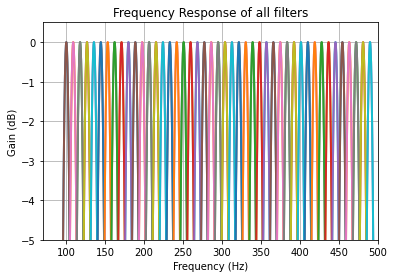

In [19]:
# FILTERING
audio_filtered_complete = filtering(array_audio_signals, sub_arrays, frequency_bands, f_sampling, array_matrices[array].get_elements())

In [21]:
# start scanning after sources, at all different angles, 
intensity_maps = scanning(y_listen, x_listen, r_scan, frequency_bands, audio_filtered_complete, array_matrices, f_sampling, sub_arrays)


 x_ind: 1
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 2
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 3
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 4
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 5
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 6
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 7
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 8
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 9
	 y_ind: 1 2 3 4 5 6 7 8 9 10 
 x_ind: 10
	 y_ind: 1 2 3 4 5 6 7 8 9 10 

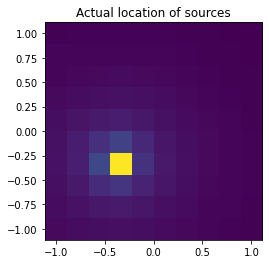

In [22]:
# Check where the source is actually located
validation_check(y_listen, x_listen, sources, r_scan)

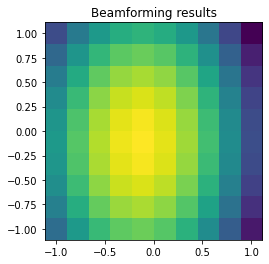

In [24]:
# show the beamforming results
total_intensity = show_beamforming_results(y_listen, x_listen, intensity_maps)